In [1]:
import numpy as np
import os
import argparse
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import ascii
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from sedpy import observate

### Define a function that returns a flux (in units of maggies) given an AB magnitude

In [2]:
def flux(mag):
    flux = 10.**(mag/(-2.5))
    return flux

### Define a function that returns inverse variance (in units of magnitudes) given a magnitude and an uncertainty on that magnitude

In [3]:
def ivar(flux, unc, wise):
    if wise:
        #flux = 10.**(mag/(-2.5))
        func = flux / 1.086 * unc
        ivar = 1 / func**2
    else:
        flux = 10.**(flux/(-2.5))
        func = flux / 1.086 * unc
        ivar = 1 / func**2
    return ivar

# Read umeh table into pandas dataframe

In [4]:
umeh = pd.read_csv('umeh_table.dat', sep=r'\s{1,}', engine='python', index_col=0)

In [5]:
umeh.head()

,fuv_mag,fuv_unc,nuv_mag,nuv_unc,u_mag,u_unc,g_mag,g_unc,r_mag,r_unc,...,w1_mag,w1_unc,w2_mag,w2_unc,w3_mag,w3_unc,w4_mag,w4_unc,z,ebv
Galaxy,,,,,,,,,,,,,,,,,,,,,
J0826,22.430,0.157,20.393,0.039,19.641,0.034,19.429,0.011,19.139,0.014,...,15.395,0.023,15.146,0.062,11.489,0.156,8.534,0.271,0.603,0.037
J0901,22.036,0.119,20.112,0.039,19.518,0.029,19.288,0.012,18.825,0.011,...,15.242,0.022,15.012,0.064,11.677,0.205,8.716,0.352,0.459,0.057
J0905,23.657,0.430,20.918,0.059,19.911,0.040,19.589,0.014,19.584,0.016,...,15.811,0.027,15.616,0.080,11.763,0.166,8.854,0.305,0.712,0.031
J0944,22.572,0.312,21.238,0.102,20.293,0.049,19.801,0.015,19.295,0.015,...,15.505,0.028,15.186,0.078,11.265,0.142,8.488,0.286,0.514,0.026
J1107,22.919,0.354,21.398,0.104,19.971,0.039,19.517,0.013,19.069,0.012,...,15.586,0.028,14.927,0.057,10.774,0.081,8.254,0.205,0.467,0.076


### Convert maggies into flux

In [6]:
umeh_flux = pd.DataFrame({'fuv_f':flux(umeh.fuv_mag), 'fuv_ivar':ivar(umeh.fuv_mag, umeh.fuv_unc, False),
                          'nuv_f':flux(umeh.nuv_mag), 'nuv_ivar':ivar(umeh.nuv_mag, umeh.nuv_unc, False),
                          'u_f':flux(umeh.u_mag), 'u_ivar':ivar(umeh.u_mag, umeh.u_unc, False),
                          'g_f':flux(umeh.g_mag), 'g_ivar':ivar(umeh.g_mag, umeh.g_unc, False),
                          'r_f':flux(umeh.r_mag), 'r_ivar':ivar(umeh.r_mag, umeh.r_unc, False),
                          'i_f':flux(umeh.i_mag), 'i_ivar':ivar(umeh.i_mag, umeh.i_unc, False),
                          'z_f':flux(umeh.z_mag), 'z_ivar':ivar(umeh.z_mag, umeh.z_unc, False),
                          'w1_f':flux(umeh.w1_mag)*306.681/3631, 'w1_ivar':np.zeros(umeh.shape[0], dtype = int),
                          'w2_f':flux(umeh.w2_mag)*170.663/3631, 'w2_ivar':np.zeros(umeh.shape[0], dtype = int),
                          'w3_f':flux(umeh.w3_mag)*29.0448/3631, 'w3_ivar':np.zeros(umeh.shape[0], dtype = int),
                          'w4_f':flux(umeh.w4_mag)*8.2839/3631, 'w4_ivar':np.zeros(umeh.shape[0], dtype = int)}, index=umeh.index.values)

umeh_flux.w1_ivar = ivar(umeh_flux.w1_f, umeh.w1_unc, True)
umeh_flux.w2_ivar = ivar(umeh_flux.w2_f, umeh.w2_unc, True)
umeh_flux.w3_ivar = ivar(umeh_flux.w3_f, umeh.w3_unc, True)
umeh_flux.w4_ivar = ivar(umeh_flux.w4_f, umeh.w4_unc, True)
umeh_flux.head()

,fuv_f,fuv_ivar,nuv_f,nuv_ivar,u_f,u_ivar,g_f,g_ivar,r_f,r_ivar,...,z_f,z_ivar,w1_f,w1_ivar,w2_f,w2_ivar,w3_f,w3_ivar,w4_f,w4_ivar
J0826,1.066596e-09,4.205914e+19,6.963058e-09,1.599302e+19,1.391874e-08,5.266254e+18,1.691999e-08,3.404664e+19,2.210039e-08,1.231980e+19,...,2.876074e-08,6.738201e+17,5.870304e-08,6.469679e+17,4.108782e-08,1.817398e+17,2.029748e-07,1.176322e+15,8.802552e-07,2.072545e+13
J0901,1.533204e-09,3.542956e+19,9.019864e-09,9.530824e+18,1.558834e-08,5.771167e+18,1.926637e-08,2.206466e+19,2.951209e-08,1.119114e+19,...,3.735941e-08,7.309738e+17,6.758660e-08,5.334492e+17,4.648503e-08,1.332519e+17,1.707034e-07,9.630917e+14,7.444038e-07,1.717739e+13
J0905,3.445085e-10,5.374310e+19,4.293387e-09,1.838043e+19,1.085425e-08,6.256618e+18,1.460158e-08,2.822303e+19,1.466898e-08,2.141015e+19,...,2.165708e-08,4.988190e+17,4.001848e-08,1.010208e+18,2.665098e-08,2.594498e+17,1.577038e-07,1.720914e+15,6.555542e-07,2.950141e+13
J0944,9.358365e-10,1.383409e+19,3.197422e-09,1.108816e+19,7.634841e-09,8.426893e+18,1.201158e-08,3.633098e+19,1.914256e-08,1.430465e+19,...,2.370282e-08,7.473222e+17,5.304697e-08,5.345919e+17,3.960164e-08,1.236073e+17,2.494837e-07,9.397205e+14,9.183508e-07,1.709663e+13
J1107,6.798295e-10,2.036353e+19,2.759307e-09,1.432165e+19,1.027070e-08,7.350729e+18,1.560271e-08,2.866639e+19,2.357219e-08,1.473999e+19,...,3.299134e-08,1.127551e+18,4.923349e-08,6.206151e+17,5.027049e-08,1.436427e+17,3.921409e-07,1.168975e+15,1.139223e-06,2.162394e+13


In [7]:
wave = np.array([0.1528, 0.2271, 0.3543, 0.477, 0.6231, 0.7625, 0.9134, 3.368, 4.618, 12.082, 22.194])
templates = ['Composite1', 'Composite2', 'Composite3', 'AGN1', 'AGN2', 'AGN3', 'AGN4', 'SFG1', 'SFG2', 'SFG3', 
             'IR_COLOR1', 'IR_COLOR2', 'IR_COLOR3', 'IR_COLOR4', 'IR_COLOR5', 'IR_COLOR6', 'IR_COLOR7', 'IR_COLOR8']
gals = ['J0826', 'J0901', 'J0905', 'J0944', 'J1107', 'J1219', 'J1341', 'J1506', 'J1558', 'J1613', 'J2116', 'J2140']
cols = {'Composite1':'silver', 'Composite2':'rosybrown', 'Composite3':'darksalmon', 
        'AGN1':'cornflowerblue', 'AGN2':'blue', 'AGN3':'slateblue', 'AGN4':'paleturquoise', 
        'SFG1':'blueviolet', 'SFG2':'plum', 'SFG3':'mediumorchid',
        'IR_COLOR1':'olive', 'IR_COLOR2':'olivedrab', 'IR_COLOR3':'yellowgreen', 'IR_COLOR4':'greenyellow', 
        'IR_COLOR5':'lawngreen', 'IR_COLOR6':'lightgreen', 'IR_COLOR7':'darkgreen', 'IR_COLOR8':'aquamarine'}
fits_cols = ['galaxy', 'template_name', 'filter', 'mags', 'wave_eff', 'model_phot']

# Read templates

In [8]:
#Read the template into a data frame. Name columns something convenient.
def read_template(name):
    temps_path = 'kirkpatrick/'
    temp = pd.read_csv(temps_path+name+'.txt',
                       names=['rest_wavelength','luminosity','DLnu'],
                       skiprows=[0, 1, 2, 3],
                       sep=r'\s{1,}',
                       engine='python')
    return temp

# Function to match a target wavelength's position.
def mask_wave(temp_wavel, target_wave):
    return np.abs(temp_wavel-target_wave) == np.amin(np.abs(temp_wavel-target_wave))

Function to scale a template using the W1 flux as reference - inputs are galaxy name, and name of template. Plots result, returns scaling factor for luminosity of template.

In [9]:
tempsdf = pd.DataFrame([],columns=['rest_wavelength','luminosity','DLnu'])
for temp_name in templates:
    newdf = read_template(temp_name)
    newdf['template_name'] = [temp_name for i in range(newdf.shape[0])]
    tempsdf = tempsdf.append(newdf)

In [10]:
def scale_lum(gal_name, template_name):
    z = umeh.loc[gal_name, 'z']
    template = tempsdf[tempsdf.template_name == template_name]
    
    # ----- Organizing wavelength and luminosity
    z_temp_wavel = template.rest_wavelength*(1+z)
    gal_fluxes = umeh_flux.loc[gal_name,::2].values
    W1_wavelength = wave[7]
    # Figure out where the template lines up with W1
    mask = mask_wave(z_temp_wavel, W1_wavelength)
    # Scale template to match value at W1
    factor = gal_fluxes[7]/float(template.luminosity[mask].values[0])
    luminosity = template.luminosity*factor # Scale
    
    
def whatever(gal_name, template_name):
    z = umeh.loc[gal_name, 'z']
    template = tempsdf[tempsdf.template_name == template_name]
    
    # ----- Organizing wavelength and luminosity
    z_temp_wavel = template.rest_wavelength*(1+z)
    gal_fluxes = umeh_flux.loc[gal_name,::2].values
    W1_wavelength = wave[7]
    # Figure out where the template lines up with W1
    mask = mask_wave(z_temp_wavel, W1_wavelength)
    # Scale template to match value at W1
    factor = gal_fluxes[7]/float(template.luminosity[mask].values[0])
    luminosity = template.luminosity*factor # Scale
    
    # ----- Readying wavelength and flux for sedpy
    wave_aa = np.array(z_temp_wavel[0:-1]) * 1e4
    flux = np.array(luminosity[0:-1])
    fnu = flux * 3631. * 1e-23
    flambda = fnu * 2.998e18 / (wave_aa)**2

    # ----- Using sedpy to get wise band photometry based on templates
    filternames = ['wise_w{}'.format(n) for n in ['1', '2', '3', '4']]
    wise_filters = observate.load_filters(filternames)
    model_mags = observate.getSED(wave_aa, flambda, filterlist=wise_filters)
    wave_eff = [f.wave_effective for f in wise_filters]
    model_phot = 10.**(model_mags/(-2.5))
    
    
    rows = pd.DataFrame([[gal_name, template_name, filternames[i], 
             model_mags[i], wave_eff[i], model_phot[i]] for i in range(len(filternames))], columns=fits_cols)
    return rows

## Making color vs color plots
We first create a new data frame containing the numerical information for the fits of the galaxies. This bit of code is the most recently written - codes further below could make use of this table in the future instead of calculating model_phot information every recursion.

In [51]:
sed_fits = pd.DataFrame([],columns=fits_cols)

for gal in umeh.index.values:
    print("---Fitting ", gal)
    for tem in templates:
        sed_fits = sed_fits.append(whatever(gal, tem))
sed_fits.reset_index(inplace=True, drop=True)
sed_fits.head()

---Fitting  J0826
---Fitting  J0901
---Fitting  J0905
---Fitting  J0944
---Fitting  J1107
---Fitting  J1219
---Fitting  J1341
---Fitting  J1506
---Fitting  J1558
---Fitting  J1613
---Fitting  J2116
---Fitting  J2140


,galaxy,template_name,filter,mags,wave_eff,model_phot
0,J0826,Composite1,wise_w1,18.461331,33461.020441,4.125416e-08
1,J0826,Composite1,wise_w2,18.349441,45952.089779,4.573235e-08
2,J0826,Composite1,wise_w3,16.670597,115526.288571,2.146649e-07
3,J0826,Composite1,wise_w4,15.840184,220783.488779,4.612393e-07
4,J0826,Composite2,wise_w1,18.475097,33461.020441,4.073439e-08


## Making indidual plots for each galaxy of color vs. color showing all filters

In [138]:
with PdfPages('sed_fitting_colorplots.pdf') as pdf:
    for galaxy in gals:
        print("---Making color plot: ", galaxy)
        fig = plt.figure(figsize=(17,10))
        ax = fig.add_subplot()
        sedf_g = sed_fits.copy()[sed_fits.galaxy == galaxy].reset_index(drop=True)
        
        w2 = sedf_g[sedf_g['filter'] == 'wise_w2'].model_phot.array
        w3 = sedf_g[sedf_g['filter'] == 'wise_w3'].model_phot.array
        w4 = sedf_g[sedf_g['filter'] == 'wise_w4'].model_phot.array
        sns.scatterplot(x=w2-w3, y=w3-w4, 
                        data=sedf_g[sedf_g['filter'] == 'wise_w2'], hue='template_name', ax=ax)
        ax.set_title(galaxy)
        ax.set_ylabel('W3-W4')
        ax.set_xlabel('W2-W3')
        pdf.savefig(bbox_inches="tight")
        plt.close('all')
    print('Finished!')

---Making color plot:  J0826
---Making color plot:  J0901
---Making color plot:  J0905
---Making color plot:  J0944
---Making color plot:  J1107
---Making color plot:  J1219
---Making color plot:  J1341
---Making color plot:  J1506
---Making color plot:  J1558
---Making color plot:  J1613
---Making color plot:  J2116
---Making color plot:  J2140
Finished!


### Color vs color plot showing different filters

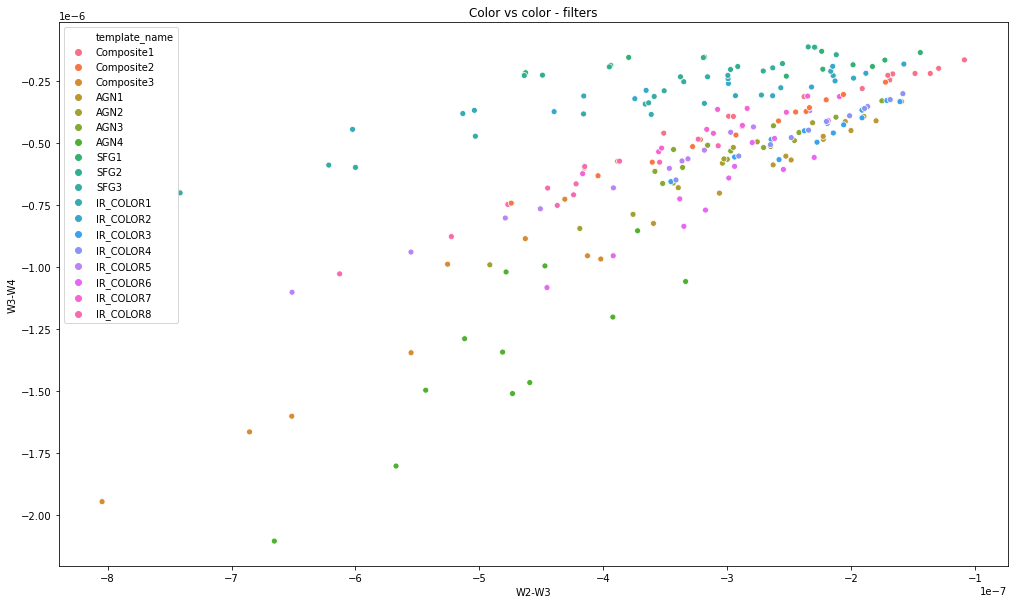

In [140]:
fig = plt.figure(figsize=(17,10))
ax = fig.add_subplot()
sns.scatterplot(x=sed_fits[sed_fits['filter'] == 'wise_w2'].model_phot.array-sed_fits[sed_fits['filter'] == 'wise_w3'].model_phot.array, 
                y=sed_fits[sed_fits['filter'] == 'wise_w3'].model_phot.array-sed_fits[sed_fits['filter'] == 'wise_w4'].model_phot.array, 
                data=sed_fits.iloc[::4,:].reset_index(), hue='template_name', ax=ax)
ax.set_ylabel('W3-W4')
ax.set_xlabel('W2-W3')
ax.set_title('Color vs color - filters')
plt.savefig('color_byfilt.png')

### Color vs color plots showing different galaxies

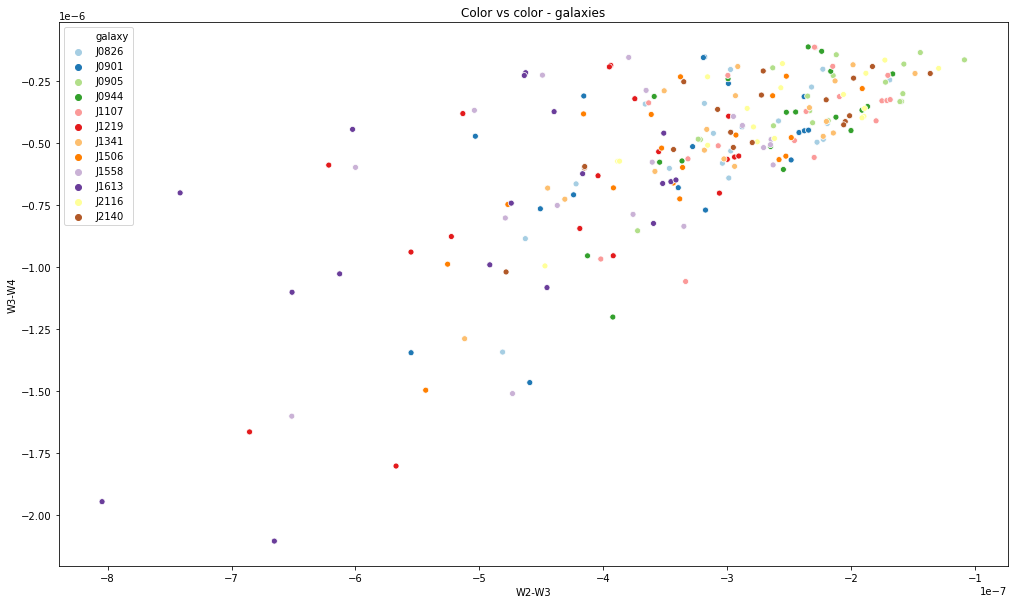

In [141]:
fig = plt.figure(figsize=(17,10))
ax = fig.add_subplot()
sns.scatterplot(x=sed_fits[sed_fits['filter'] == 'wise_w2'].model_phot.array-sed_fits[sed_fits['filter'] == 'wise_w3'].model_phot.array, 
                y=sed_fits[sed_fits['filter'] == 'wise_w3'].model_phot.array-sed_fits[sed_fits['filter'] == 'wise_w4'].model_phot.array, 
                data=sed_fits.iloc[::4,:].reset_index(), hue='galaxy', palette='Paired')
ax.set_ylabel('W3-W4')
ax.set_xlabel('W2-W3')
ax.set_title('Color vs color - galaxies')
plt.savefig('color_bygal.png')

## The code below makes plots for fitting templates to galaxies
This code makes 200+ plots - each showing how a template fits a galaxy. 

In [12]:
def fit_template(gal_name, template_name):
    z = umeh.loc[gal_name, 'z']
    template = read_template(template_name)
    
    # ----- Organizing wavelength and luminosity
    z_temp_wavel = template.rest_wavelength*(1+z)
    gal_fluxes = umeh_flux.loc[gal_name,::2].values
    W1_wavelength = wave[7]
    # Figure out where the template lines up with W1
    mask = mask_wave(z_temp_wavel, W1_wavelength)
    # Scale template to match value at W1
    factor = gal_fluxes[7]/float(template.luminosity[mask].values[0])
    luminosity = template.luminosity*factor # Scale
    
    # ----- Readying wavelength and flux for sedpy
    wave_aa = np.array(z_temp_wavel[0:-1]) * 1e4
    flux = np.array(luminosity[0:-1])
    fnu = flux * 3631. * 1e-23
    flambda = fnu * 2.998e18 / (wave_aa)**2

    # ----- Using sedpy to get wise band photometry based on templates
    filternames = ['wise_w{}'.format(n) for n in ['1', '2', '3', '4']]
    wise_filters = observate.load_filters(filternames)
    model_mags = observate.getSED(wave_aa, flambda, filterlist=wise_filters)
    wave_eff = [f.wave_effective for f in wise_filters]
    model_phot = 10.**(model_mags/(-2.5))
    
    gal_unc = np.sqrt(umeh_flux.iloc[:,1::2].loc[gal_name].values**-1)
    chi = np.sum(np.array([((gal_fluxes[i+8] - model_phot[i+1])/gal_unc[i+8])**2 for i in range(3)]))/3
    
    # Plot
    plot = True

    if plot:
        plot_color = cols[template_name]
        title = gal_name+'-'+template_name
        fig = plt.figure(figsize=(17,10))
        ax = fig.add_subplot()
        g = sns.lineplot(x=z_temp_wavel, y=luminosity, ax=ax, color='green', alpha=0.8)
        h = sns.scatterplot(x=wave, y=gal_fluxes, ax=ax, color=plot_color, label=template_name)
        ax.scatter(x=np.array(wave_eff)/1e4, y=model_phot, color='red', s=11)
        ax.errorbar(wave, gal_fluxes, yerr=gal_unc, color='blue', ls='none')
        plt.text(10, 10**-2.5, str(chi), ha='center')
        ax.set_ylim([1e-10,1e-3])
        ax.set_xlim([0.1, 1000.])
        ax.loglog()
        ax.legend()
        ax.set_title(title)
        plt.ioff()
        #plt.savefig(title+'.png')
        #plt.clf()
        #plt.close()
        
    
    return(chi)

11.718190852051409


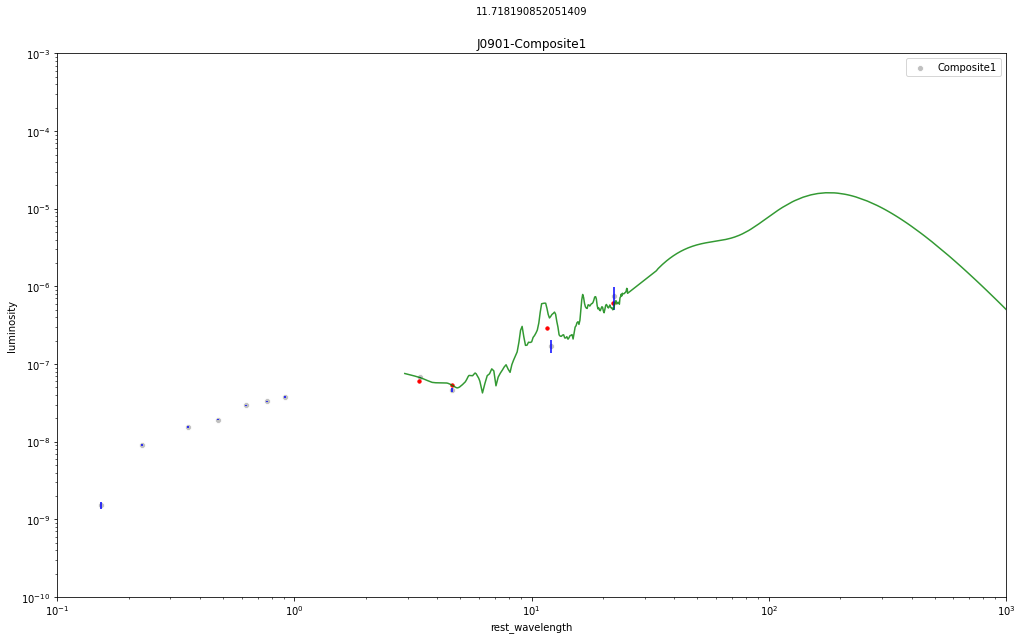

In [13]:
factor1 = fit_template('J0901', 'Composite1')
print(factor1)

In [73]:
with PdfPages('sed_fitting.pdf') as pdf:
    for gal in umeh.index.values:
        print("---Fitting ", gal)
        chis = []
        for tem in templates:
            new_chi = fit_template(gal, tem)
            chis.append(new_chi)
            pdf.savefig(bbox_inches="tight")
            plt.close('all')
        bestchi_pos = chis.index(min(chis))
        print("Galaxy - ", gal, " - lowest chi tempalte: ", templates[bestchi_pos])

---Fitting  J0826
Galaxy -  J0826  - lowest chi tempalte:  IR_COLOR2
---Fitting  J0901
Galaxy -  J0901  - lowest chi tempalte:  SFG1
---Fitting  J0905
Galaxy -  J0905  - lowest chi tempalte:  SFG2
---Fitting  J0944
Galaxy -  J0944  - lowest chi tempalte:  SFG1
---Fitting  J1107
Galaxy -  J1107  - lowest chi tempalte:  SFG3
---Fitting  J1219
Galaxy -  J1219  - lowest chi tempalte:  SFG1
---Fitting  J1341
Galaxy -  J1341  - lowest chi tempalte:  SFG2
---Fitting  J1506
Galaxy -  J1506  - lowest chi tempalte:  SFG2
---Fitting  J1558
Galaxy -  J1558  - lowest chi tempalte:  Composite1
---Fitting  J1613
Galaxy -  J1613  - lowest chi tempalte:  IR_COLOR1
---Fitting  J2116
Galaxy -  J2116  - lowest chi tempalte:  SFG2
---Fitting  J2140
Galaxy -  J2140  - lowest chi tempalte:  SFG3


## New SED fitting code that shows all templates in one set of axes for each galaxy
Generates pdf with 12 pages instead of 200+

In [14]:
def fit_template1(gal_name, template_name):
    z = umeh.loc[gal_name, 'z']
    template = read_template(template_name)
    
    # ----- Organizing wavelength and luminosity
    z_temp_wavel = template.rest_wavelength*(1+z)
    gal_fluxes = umeh_flux.loc[gal_name,::2].values
    W1_wavelength = wave[7]
    # Figure out where the template lines up with W1
    mask = mask_wave(z_temp_wavel, W1_wavelength)
    # Scale template to match value at W1
    factor = gal_fluxes[7]/float(template.luminosity[mask].values[0])
    luminosity = template.luminosity*factor # Scale
    
    # ----- Readying wavelength and flux for sedpy
    wave_aa = np.array(z_temp_wavel[0:-1]) * 1e4
    flux = np.array(luminosity[0:-1])
    fnu = flux * 3631. * 1e-23
    flambda = fnu * 2.998e18 / (wave_aa)**2

    # ----- Using sedpy to get wise band photometry based on templates
    filternames = ['wise_w{}'.format(n) for n in ['1', '2', '3', '4']]
    wise_filters = observate.load_filters(filternames)
    model_mags = observate.getSED(wave_aa, flambda, filterlist=wise_filters)
    wave_eff = [f.wave_effective for f in wise_filters]
    model_phot = 10.**(model_mags/(-2.5))
    
    gal_unc = np.sqrt(umeh_flux.iloc[:,1::2].loc[gal_name].values**-1)
    chi = np.sum(np.array([((gal_fluxes[i+8] - model_phot[i+1])/gal_unc[i+8])**2 for i in range(3)]))/3
    
    # Plot
    plot = True

    if plot:
        plot_color = cols[template_name]
        title = gal_name+'-'+template_name

        g = sns.lineplot(x=z_temp_wavel, y=luminosity, color=plot_color, label=template_name, alpha=0.6, ax=ax)
        h = sns.scatterplot(x=wave, y=gal_fluxes, ax=ax, color='blue')
        #ax.scatter(x=np.array(wave_eff)/1e4, y=model_phot, color='red', s=11)
        ax.errorbar(wave, gal_fluxes, yerr=gal_unc, color='blue', ls='none')
        ax.set_ylim([1e-10,1e-3])
        ax.set_xlim([0.1, 1000.])
        ax.loglog()
        ax.legend()
        ax.set_title(title)
        plt.ioff()
        #plt.savefig(title+'.png')
        #plt.clf()
        #plt.close()
        
    
    return(chi)

In [139]:
with PdfPages('sed_fitting2.pdf') as pdf:
    for gal in umeh.index.values:
        fig = plt.figure(figsize=(17,10))
        ax = fig.add_subplot()
        print("---Fitting ", gal)
        chis = []
        for tem in templates:
            new_chi = fit_template1(gal, tem)
            chis.append(new_chi)
        bestchi_pos = chis.index(min(chis))
        result_string = "Galaxy - " + gal + " - lowest chi tempalte: " + str(templates[bestchi_pos])
        print(result_string)
        plt.text(10, 10**-2.5, result_string, ha='center')
        pdf.savefig(bbox_inches="tight")
        plt.close('all')

---Fitting  J0826
Galaxy - J0826 - lowest chi tempalte: Composite1
---Fitting  J0901
Galaxy - J0901 - lowest chi tempalte: Composite1
---Fitting  J0905
Galaxy - J0905 - lowest chi tempalte: IR_COLOR2
---Fitting  J0944
Galaxy - J0944 - lowest chi tempalte: IR_COLOR2
---Fitting  J1107
Galaxy - J1107 - lowest chi tempalte: SFG3
---Fitting  J1219
Galaxy - J1219 - lowest chi tempalte: IR_COLOR2
---Fitting  J1341
Galaxy - J1341 - lowest chi tempalte: IR_COLOR1
---Fitting  J1506
Galaxy - J1506 - lowest chi tempalte: IR_COLOR1
---Fitting  J1558
Galaxy - J1558 - lowest chi tempalte: IR_COLOR2
---Fitting  J1613
Galaxy - J1613 - lowest chi tempalte: IR_COLOR1
---Fitting  J2116
Galaxy - J2116 - lowest chi tempalte: Composite1
---Fitting  J2140
Galaxy - J2140 - lowest chi tempalte: Composite1
